## Machine Vision

**Program untuk klasifikasi karakter tulisan tangan pada dataset EMNIST (Extended MNIST) menggunakan HOG Feature Extraction dengan klasifier Support Vector Machine (SVM) dan lakukan evaluasi performa menggunakan Leave-One-Out-Cross-Validation (LOOCV) dengan menampilkan confussion matrix, accuracy, precision dan F1-score.**

In [241]:
import os #mengambil informasi tentang file, dan menjalankan perintah sistem.
import pandas as pd #untuk manipulasi dan analisis data.
import numpy as np
import matplotlib.pyplot as plt #untuk membuat visualisasi data dalam bentuk grafik dan plot
from numpy import mean
from mlxtend.plotting import plot_confusion_matrix #untuk memvisualisasikan matriks 
from skimage.feature import hog #untuk menghitung Histogram of Oriented Gradients (HOG)
from sklearn.preprocessing import LabelBinarizer #untuk mengubah label kategorikal menjadi format biner
from sklearn import datasets #untuk pengujian dan pelatihan model
from sklearn.svm import SVC #digunakan untuk klasifikasi data
from sklearn.model_selection import LeaveOneOut #validasi silang dalam dataset digunakan sebagai data uji satu per satu
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, make_scorer

## 1. Dataset Preparation

**Download MNIST dataset**

In [245]:
# https://www.kaggle.com/datasets/crawford/emnist/data 

**Load image dataset**

In [248]:
train_data = pd.read_csv('./EMNIST/emnist-bymerge-train.csv')
test_data = pd.read_csv('./EMNIST/emnist-bymerge-test.csv')
label_map = pd.read_csv('./EMNIST/emnist-bymerge-mapping.txt', sep='\\s+', header=None)

**Mapping From CSV**

In [251]:
mapping_dict = {row[0]: chr(row[1]) for _, row in label_map.iterrows()}
train_img = np.array(train_data.iloc[:,1:].values)
train_lbl = np.array(train_data.iloc[:,0].values)


test_img = np.array(test_data.iloc[:,1:].values)
test_lbl = np.array(test_data.iloc[:,0].values)

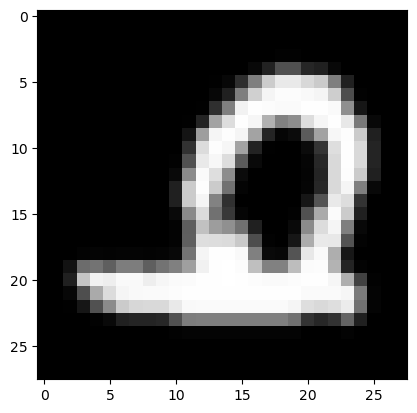

In [253]:
plt.imshow(train_img[0].reshape(28,28), cmap='gray')

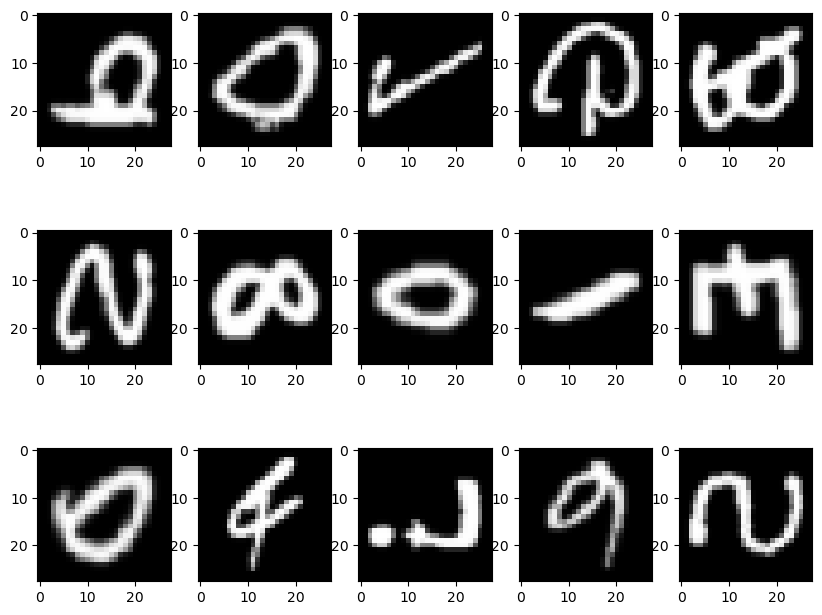

In [254]:
fig, axes = plt.subplots(3,5,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(train_img[i].reshape([28,28]), cmap='gray')

**ROTATE IMAGE**

In [257]:
def rotate(i):
    i = i.reshape([28, 28])
    i = np.fliplr(i)
    i= np.rot90(i)
    return i.flatten()

train_rot = np.apply_along_axis(rotate, 1, train_img)
test_rot = np.apply_along_axis(rotate, 1, test_img)   

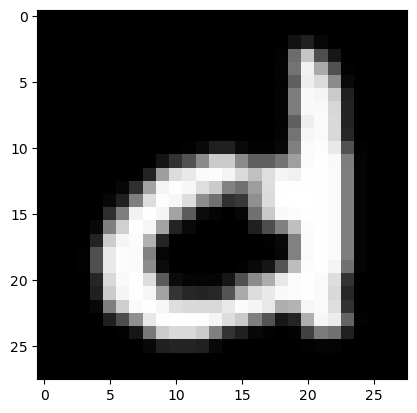

In [258]:
plt.imshow(train_rot[0].reshape(28,28), cmap='gray') 

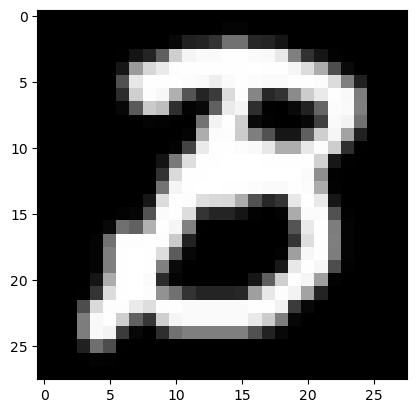

In [259]:
plt.imshow(train_rot[4].reshape(28,28), cmap='gray')

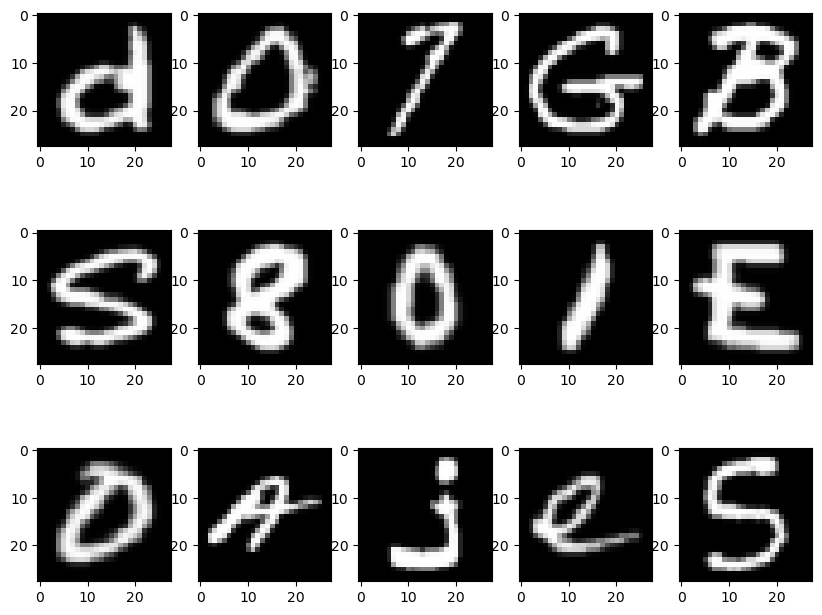

In [260]:
fig, axes = plt.subplots(3,5,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(train_rot[i].reshape([28,28]), cmap='gray')

**Test extract HOG feature from image**

In [262]:
feature, hog_img = hog(train_rot[0].reshape(28,28),orientations=9,pixels_per_cell=(8,8),cells_per_block=(2,2),visualize=True,block_norm='L2')

<BarContainer object of 144 artists>

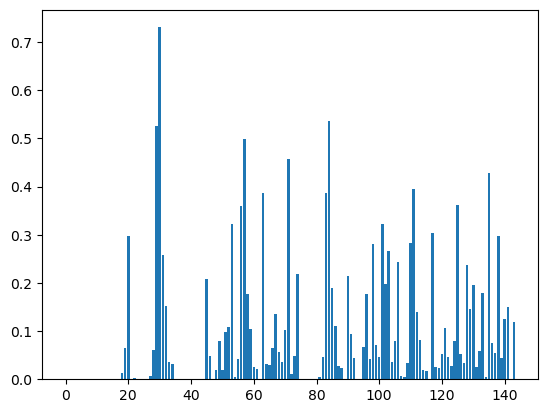

In [265]:
plt.bar(list(range(feature.shape[0])),feature)

## 2. Preprocessing using HOG Feature Extraction

In [269]:
n_dims = feature.shape[0]
n_samples_train= train_rot.shape[0]
x_train, y_train = datasets.make_classification(n_samples=n_samples_train, n_features=n_dims)

n_samples_test= test_rot.shape[0]
x_test, y_test = datasets.make_classification(n_samples=n_samples_test, n_features=n_dims)

## 3. HOG Feature

In [271]:

def hog_features (img_data, label_data, xdata, ydata):
    n_samples = img_data.shape[0]

    for i in range(n_samples):
        xdata[i], _ = hog(img_data[i].reshape(28,28), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2')
        ydata[i] = label_data[i]

        return xdata, ydata

In [272]:
lb = LabelBinarizer()
lb.fit(y_train)

LabelBinarizer()

In [273]:
train_hog = hog_features (train_img, train_lbl, x_train, y_train)
test_hog =  hog_features (test_img, test_lbl, x_test, y_test)

x_train_hog = train_hog[0]
y_train_hog = train_hog[1]
x_test_hog = test_hog[0]
y_test_hog = test_hog[1]

## 4. SVM & LOOCV

In [277]:
# Implementing LOOCV with SVM
loo = LeaveOneOut()
model = SVC(kernel='rbf', C=100, gamma='scale', random_state=42)

## 5. Evaluation Metrics

### 5. 1 Confussion Matrix

In [282]:
y_pred = cross_val_score(model, x_test_hog, y_test_hog, cv=loo, n_jobs=-1)

In [286]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_hog, y_pred)

In [288]:
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[ 68 430   0]
 [ 82 419   0]
 [  1   0   0]]


### 5.2 Precission

$$\text { Precision }=\frac{T P}{T P+F P}$$

In [291]:
#scores_precision = cross_val_score(model, x_test_hog, y_test_hog, scoring='precision_weighted', cv=loo, n_jobs=-1)
Precision = precision_score(y_test_hog, y_pred, average='micro')

In [292]:
#print(f'Precision Scores from LOOCV: {scores_precision}')
#print(f'Mean Precision Score: {np.mean(scores_precision):.3f}')

In [293]:
print(f'Precision: {precision:.4f}')

Precision: 0.5071


### 5.3 Accuracy

In [295]:
accuracy = accuracy_score(y_test_hog, y_pred)

In [296]:
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.4870


### 5.4 F1-Score

In [298]:
f1 = f1_score(y_test_hog, y_pred, average='weighted')

In [299]:
print(f'F1 Score: {f1:.4f}')

F1 Score: 0.4153
